In [1]:
from src.inference.segment_inference import inference
import cv2
from pytesseract import pytesseract
from src.config.llm import llm
from dotenv import load_dotenv

load_dotenv()
path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.tesseract_cmd = path_to_tesseract

In [2]:
image_origin = cv2.imread("./src/data/resume-for-fresher-template-281.jpg")
outputs = inference(
    image_origin,
    model_path="./src/model/segment.onnx",
    threshold_confidence=0.7,
    threshold_iou=0.7,
)


In [3]:
from src.utils.utils_segment import draw_bounding_boxes
image = draw_bounding_boxes(image_origin, outputs)

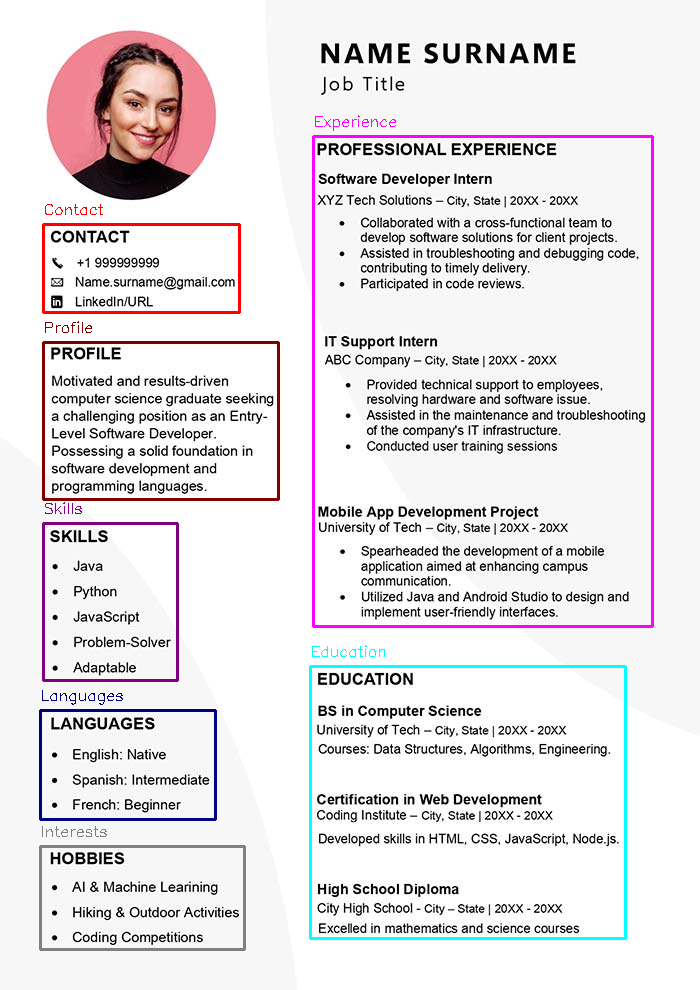

In [4]:
image

In [5]:
def extract_text_dict(outputs):
    result_dict = {}
    for output in outputs:
        label = output.get("label").lower()
        text = output.get("text")
        if label in result_dict:
            result_dict[label] += " " + text
        else:
            result_dict[label] = text
    return result_dict
outputs = extract_text_dict(outputs)
outputs

{'experience': 'PROFESSIONAL EXPERIENCE\n\nSoftware Developer Intern\nXYZ Tech Solutions — City, State | 20Xx - 20xx\n\n* Collaborated with a cross-functional team to\ndevelop software solutions for client projects.\n\n‘+ Assisted in troubleshooting and debugging code,\ncontributing to timely delivery.\n\n+ Patticipated in code reviews.\n\nIT Support Intern\n‘ABC Company ~ City, State | 20XX - 20xX\n\n+ Provided technical support to employees,\nresolving hardware and software issue.\n\n‘+ Assisted in the maintenance and troubleshooting\nof the company’s IT infrastructure.\n\n+ Conducted user training sessions\n\nMobile App Development Project\nUniversity of Tech — City, State | 20XX - 20xX\n\n‘+ Spearheaded the development of a mobile\napplication aimed at enhancing campus\n‘communication,\n\n+ Utilized Java and Android Studio to design and\nimplement user-friendly interfaces.\nPROFESSIONAL EXPERIENCE\n\nSoftware Developer Intern\nXYZ Tech Solutions — City, State | 20Xx - 20xx\n\n* Col

In [6]:
prompt = """
#Role: You are an expert at correcting spelling errors from interviewee's resume information.
#Instruction:
You are provided with a dictionary containing information from the user's resume by an OCR model. It may have misspellings or wrong entries.
Please correct the spelling of each field.
Move the content of the fields to more appropriate fields if necessary.
You must not fabricate information and create new information.

You must return JSON containing the same format as the original format:

#Input:
My resume is as follows: {input}
"""

In [7]:
input = prompt.format(input=outputs)

In [34]:
# response = llm.invoke(input)

In [35]:
import json
from langchain_core.output_parsers import JsonOutputParser



In [38]:
response_parser = JsonOutputParser().parse(response)
response_parser

{'experience': [{'title': 'Software Developer Intern',
   'company': 'XYZ Tech Solutions',
   'location': 'City, State',
   'years': '20XX - 20XX',
   'description': '- Collaborated with a cross-functional team to develop software solutions for client projects.\n- Assisted in troubleshooting and debugging code, contributing to timely delivery.\n- Participated in code reviews.'},
  {'title': 'IT Support Intern',
   'company': 'ABC Company',
   'location': 'City, State',
   'years': '20XX - 20XX',
   'description': '- Provided technical support to employees, resolving hardware and software issues.\n- Assisted in the maintenance and troubleshooting of the company’s IT infrastructure.\n- Conducted user training sessions.'},
  {'title': 'Mobile App Development Project',
   'company': 'University of Tech',
   'location': 'City, State',
   'years': '20XX - 20XX',
   'description': '- Spearheaded the development of a mobile application aimed at enhancing campus communication.\n- Utilized Java 